In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs
import time
import json
import os
import re

# Load the CSV file
df = pd.read_csv("/Users/lgfolder/Downloads/rtw.csv")

# Set for visited URLs to prevent duplicates
visited = set()

# Path to results file
results_path = "/Users/lgfolder/Downloads/pdf_results_rtw.json"
if os.path.exists(results_path):
    with open(results_path, "r") as f:
        results_log = json.load(f)
else:
    results_log = []

# Helper: Check if a URL points to a PDF
def is_pdf(url):
    return url.lower().endswith(".pdf")

# Helper: Allow only ieListDocuments URLs with CId and MId (order-insensitive)
def is_allowed_ieListDocuments_url(url):
    if not isinstance(url, str):
        return False
    parsed = urlparse(url)
    if "ieListDocuments.aspx" not in parsed.path:
        return False
    query = parse_qs(parsed.query)
    return "CId" in query and "MId" in query

# Helper: Check if it's a valid starting page (meeting list)
def is_valid_start_url(url):
    return isinstance(url, str) and url.startswith("http") and "ieListMeetings.aspx" in url

# Crawl PDFs from a specific meeting document page
def crawl_ieListDocuments_page(url, topic, source_url, depth=0, max_depth=2):
    pdf_links = set()
    if depth > max_depth or url in visited:
        return pdf_links

    if not is_allowed_ieListDocuments_url(url):
        return pdf_links

    visited.add(url)
    print(f"Crawling: {url} (depth={depth})")

    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return pdf_links
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")

    # Try to extract committee, date, and time from a heading
    committee = date = time_ = None
    heading_text = soup.find(string=re.compile(r" - .*\d{1,2}.*\d{4}"))
    if heading_text:
        match = re.match(r"(?P<committee>.+?) - .*?(?P<date>\d{1,2}(?:st|nd|rd|th)?\s+\w+,\s+\d{4})\s+(?P<time>\d{1,2}\.\d{2}\s*[ap]m)", heading_text.strip(), re.IGNORECASE)
        if match:
            committee = match.group("committee").strip()
            date = match.group("date").strip()
            time_ = match.group("time").strip()

    for a_tag in reversed(soup.find_all("a", href=True)):
        link = urljoin(url, a_tag['href'])
        if is_pdf(link):
            if link not in pdf_links:
                pdf_links.add(link)
                # Save immediately with metadata
                results_log.append({
                    "topic": topic,
                    "source_url": source_url,
                    "page_url": url,
                    "pdf_url": link,
                    "committee": committee,
                    "date": date,
                    "time": time_
                })
                with open(results_path, "w") as f:
                    json.dump(results_log, f, indent=2)
        time.sleep(0.25)

    return pdf_links

# Top-level crawler: start from meeting list, extract child meeting document pages
def crawl_from_meeting_list(start_url, topic):
    meeting_pdf_links = set()

    print(f"Scanning meeting list: {start_url}")
    try:
        resp = requests.get(start_url, timeout=10)
        if resp.status_code != 200:
            return meeting_pdf_links
    except Exception as e:
        print(f"Failed to fetch meeting list page {start_url}: {e}")
        return meeting_pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")
    for a_tag in soup.find_all("a", href=True):
        link = urljoin(start_url, a_tag['href'])
        if is_allowed_ieListDocuments_url(link):
            meeting_pdf_links |= crawl_ieListDocuments_page(link, topic, start_url)
            time.sleep(0.25)

    return meeting_pdf_links

# Run crawler for each topic
pdf_map = {}
for _, row in df.iterrows():
    topic = row.get('topic')
    start_url = row.get('mother_url')

    if not is_valid_start_url(start_url):
        print(f"Skipping (not allowed): {start_url}")
        continue

    visited.clear()
    pdf_links = crawl_from_meeting_list(start_url, topic)
    pdf_map[topic] = list(pdf_links)
    print(f"Saved {len(pdf_links)} PDFs for topic: {topic}\n")

# The pdf_map now holds topic -> [list of PDF URLs]


Scanning meeting list: https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5735&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=6006&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5998&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5732&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5916&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5917&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5731&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.asp

In [26]:
import pandas as pd
import json

# Load the JSON file
with open(results_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Drop duplicate PDF URLs, keeping the first occurrence
df_deduped = df.drop_duplicates(subset=["pdf_url"])
pd.set_option('display.max_colwidth', None)  # Show full column content
# Display the deduplicated DataFrame
df_deduped  # or just df_deduped to see all

,topic,source_url,page_url,pdf_url,committee,date,time
0,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76874/17. Date of Next Meeting.pdf,Full Council,"23rd April, 2025",6.30 pm
1,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76873/16. Common Seal of the Council.pdf,Full Council,"23rd April, 2025",6.30 pm
2,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76872/15. Urgent Business.pdf,Full Council,"23rd April, 2025",6.30 pm
3,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76856/Appendix B - Appointments to Committees.pdf,Full Council,"23rd April, 2025",6.30 pm
4,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76855/Appendix A Political balance and allocation of Committee seats.pdf,Full Council,"23rd April, 2025",6.30 pm
...,...,...,...,...,...,...,...
668,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70614/Minutes 07122023 Cabinet.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
669,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70613/4 Notification of Persons Registered to Speak.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
670,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70612/3 Declarations of Interest.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
671,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70611/2 Apologies for Absence.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm


In [15]:

# Get unique page URLs
unique_pages = df["page_url"].drop_duplicates()

# Display the count and the URLs
#print(f"Total unique page URLs: {len(unique_pages)}")
unique_pages.reset_index(drop=True)  # Nicely indexed for viewing
unique_pages

0        https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5402&Ver=4
5                     https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38964#mgDocuments
20     https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MID=5402#AI38964
48     https://democracy.tunbridgewells.gov.uk/mgParishCouncilDetails.aspx?LS=17&SLS=4&bcr=1
49                                https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38964
64                                https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38868
70     https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MID=5402#AI38868
98                 https://democracy.tunbridgewells.gov.uk/ieDecisionDetails.aspx?AIId=38762
99             https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MID=5411
118                               https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38866
120    https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CI

#### Downloading the texts and metadata from the pdfs without saving them

In [41]:
import requests
import pdfplumber
from io import BytesIO

url = "https://democracy.tunbridgewells.gov.uk/documents/s70214/15.%20Date%20of%20Next%20Meeting.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76856/Appendix B - Appointments to Committees.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76855/Appendix A Political balance and allocation of Committee seats.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76866/10 Motion on Notice from Cllr Mobbs.pdf"

def extract_text_from_pdf_url(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''
            for page in pdf.pages:
                text += page.extract_text() or ''
        return text.strip()
    except Exception as e:
        return f"Failed: {e}"

# Run it
extract_text_from_pdf_url(url)

'Date of Next Meeting\nFor Full Council on Wednesday 13 December 2023\nProcedural Item\nTo note that the next scheduled meeting is Wednesday 28 February 2024.\nPage Tunbridge Wells Borough Council\n1 of 1 Date of Next Meeting'

### Downloading pdf metadata from one url link

In [42]:
import requests
from PyPDF2 import PdfReader
from io import BytesIO
import pandas as pd


def extract_all_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        content = response.content

        reader = PdfReader(BytesIO(content))
        raw_meta = reader.metadata or {}

        # Convert keys to plain strings (e.g., "/Author" → "Author")
        meta = {k.strip('/'): v for k, v in raw_meta.items()}

        # Add general info
        meta["Pages"] = len(reader.pages)
        meta["Encrypted"] = reader.is_encrypted
        meta["FileSizeBytes"] = len(content)
        meta["PDFHeader"] = content[:8].decode("utf-8", errors="ignore").strip()

        # Page size (if available)
        try:
            box = reader.pages[0].mediabox
            meta["PageWidth"] = float(box.width)
            meta["PageHeight"] = float(box.height)
        except Exception:
            pass

        return meta
    except Exception as e:
        return {"error": str(e)}

# Example usage:
metadata = extract_all_pdf_metadata(url)
df_meta = pd.DataFrame([metadata])
df_meta

,Title,Author,Creator,CreationDate,ModDate,Producer,Pages,Encrypted,FileSizeBytes,PDFHeader,PageWidth,PageHeight
0,Date of Next Meeting,Jane Clarke,Microsoft® Word for Microsoft 365,D:20231205130031+00'00',D:20231205130031+00'00',Microsoft® Word for Microsoft 365,1,False,28509,%PDF-1.7,595.32,841.92


### Downloading metadata from all urls from the scraping results json

In [ ]:
import json
import requests
from PyPDF2 import PdfReader
from io import BytesIO
import pandas as pd
from tqdm import tqdm  # progress bar

# Load results from your scraper
with open("/Users/lgfolder/Downloads/pdf_results.json", "r") as f:
    data = json.load(f)

# Extract unique PDF URLs
pdf_urls = list({entry["pdf_url"] for entry in data if entry.get("pdf_url", "").endswith(".pdf")})

def extract_all_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        content = response.content

        reader = PdfReader(BytesIO(content))
        raw_meta = reader.metadata or {}
        meta = {k.strip('/'): v for k, v in raw_meta.items()}

        # General info
        meta["Pages"] = len(reader.pages)
        meta["Encrypted"] = reader.is_encrypted
        meta["FileSizeBytes"] = len(content)
        meta["PDFHeader"] = content[:8].decode("utf-8", errors="ignore").strip()
        meta["SourceURL"] = url

        # Page dimensions
        try:
            box = reader.pages[0].mediabox
            meta["PageWidth"] = float(box.width)
            meta["PageHeight"] = float(box.height)
        except Exception:
            pass

        return meta
    except Exception as e:
        return {"SourceURL": url, "error": str(e)}

# Run metadata extraction for each PDF
metadata_list = [extract_all_pdf_metadata(url) for url in tqdm(pdf_urls)]

# Display as DataFrame
df_meta = pd.DataFrame(metadata_list)
df_meta

100%|██████████| 109/109 [00:57<00:00,  1.91it/s]


,Title,Author,Creator,CreationDate,ModDate,Producer,Pages,Encrypted,FileSizeBytes,PDFHeader,SourceURL,PageWidth,PageHeight,Keywords,AAPL:Keywords,Subject,Trapped
0,Questions from members of the Council,Mark O'Callaghan,Microsoft® Word for Microsoft 365,D:20231208094738+00'00',D:20231208094738+00'00',Microsoft® Word for Microsoft 365,1,False,124136,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70269/Question ONLY from members of the Council 13 December.pdf,595.32,841.92,NaN,NaN,NaN,NaN
1,NaN,Helen Ward,Microsoft® Word for Microsoft 365,D:20231205115320+00'00',D:20231205115320+00'00',Microsoft® Word for Microsoft 365,4,False,116783,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70184/Appendix B.pdf,595.32,841.92,NaN,NaN,NaN,NaN
2,Notice of Use of Urgency Procedures,Jane Clarke,Microsoft® Word for Microsoft 365,D:20231130151128+00'00',D:20231130151128+00'00',Microsoft® Word for Microsoft 365,1,False,76717,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70156/9. Notice of Use of Urgency Procedures.pdf,595.32,841.92,NaN,NaN,NaN,NaN
3,Proposed Changes to the Council’s Constitution,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240322093819+00'00',D:20240322093819+00'00',Microsoft® Word for Microsoft 365,6,False,185202,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71821/Report for Changes to Consitution - APNA 2022 and PSH - FC.pdf,595.32,841.92,NaN,NaN,NaN,NaN
4,NaN,Helen Ward,Microsoft® Word for Microsoft 365,D:20240322093824+00'00',D:20240322093824+00'00',Microsoft® Word for Microsoft 365,5,False,161851,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71822/Appendix A.pdf,595.32,841.92,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Declarations of Interest,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240221102459+00'00',D:20240221102459+00'00',Microsoft® Word for Microsoft 365,1,False,67657,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71238/2. Declarations of Interest.pdf,595.32,841.92,NaN,NaN,NaN,NaN
105,Notice of Use of Urgency Procedures,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240220105745+00'00',D:20240220105745+00'00',Microsoft® Word for Microsoft 365,1,False,76176,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71194/7. Notice of Use of Urgency Procedures.pdf,595.32,841.92,NaN,NaN,NaN,NaN
106,NaN,Russell Heppleston,Microsoft® Word for Microsoft 365,D:20240209121224+00'00',D:20240209121224+00'00',Microsoft® Word for Microsoft 365,9,False,283316,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71016/Appendix A Audit Governance Committee Annual Report 2022-23.pdf,595.32,841.92,NaN,NaN,NaN,NaN
107,Strategic Risk Register,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240220101641+00'00',D:20240220101641+00'00',Microsoft® Word for Microsoft 365,5,False,127528,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71189/Appointment of TWBC IP 2024.pdf,595.32,841.92,NaN,NaN,NaN,NaN


### Scrape the full content of PDF files from links in JSONs

In [57]:
import json, time, hashlib, requests, os
from PyPDF2 import PdfReader
from io import BytesIO
import jsonlines
from tqdm import tqdm
import re
from datetime import datetime

# INPUT: Load results JSON
with open("/Users/lgfolder/Downloads/pdf_results.json", "r") as f:
    scraped_records = json.load(f)

# OUTPUT paths
jsonl_path = "/Users/lgfolder/Downloads/raw_scraped_metadata_rtw_test.jsonl"
id_register_path = "/Users/lgfolder/Downloads/document_ids_rtw_test.json"

# Convert to lookup by URL
scraped_by_url = {r["pdf_url"]: r for r in scraped_records if "pdf_url" in r}

# Load or initialize ID register
if os.path.exists(id_register_path):
    with open(id_register_path, "r") as f:
        doc_id_register = json.load(f)
else:
    doc_id_register = {}

# Track existing IDs to avoid duplication
existing_ids = set(doc["id"] for doc in doc_id_register.values())

# Utility: Generate short hash-based ID
def compute_doc_id(content):
    short_hash = hashlib.sha256(content).hexdigest()[:8]
    return f"doc_{short_hash}"

# Utility: Clean string to avoid json serialization issues
def clean_meta(meta):
    return {k.strip("/"): str(v) if v is not None else None for k, v in meta.items()}

# Utility: Extract meeting date from title or subject
def extract_meeting_date(text):
    match = re.search(r"(\d{1,2})[\-/](\d{1,2})[\-/](\d{2,4})", text)
    if match:
        d, m, y = match.groups()
        if len(y) == 2:
            y = '20' + y  # assume 21st century
        try:
            return datetime(int(y), int(m), int(d)).strftime("%Y-%m-%d")
        except:
            return None
    return None

# Classify document type from title or URL
def classify_doc_type(title, url):
    title = (title or "").lower()
    url = url.lower()
    if "agenda" in title or "agenda" in url:
        return "Agenda"
    elif "minute" in title or "minute" in url:
        return "Minutes"
    elif "report" in title or "report" in url:
        return "Report"
    return "Unknown"

# Main extractor
def extract_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=20)
        response.raise_for_status()
        content = response.content

        doc_id = compute_doc_id(content)
        if doc_id in existing_ids:
            return None, None  # already processed

        reader = PdfReader(BytesIO(content))
        raw_meta = clean_meta(reader.metadata or {})
        text = ''.join((p.extract_text() or '') for p in reader.pages)

        # Base record
        record = {
            "document_id": doc_id,
            "source_url": url,
            "title": raw_meta.get("Title"),
            "author": raw_meta.get("Author"),
            "creator": raw_meta.get("Creator"),
            "producer": raw_meta.get("Producer"),
            "created": raw_meta.get("CreationDate"),
            "modified": raw_meta.get("ModDate"),
            "subject": raw_meta.get("Subject"),
            "keywords": raw_meta.get("Keywords"),
            "pages": len(reader.pages),
            "filesize_bytes": len(content),
            "text": text.strip(),
            "word_count": len(text.split()),
            "char_count": len(text),
            "avg_words_per_page": round(len(text.split()) / max(1, len(reader.pages)), 2),
            "error": None  # placeholder for error tracking
        }

        # Scraping step 1 integration
        scraped = scraped_by_url.get(url, {})
        record.update({
            "page_url": scraped.get("page_url"),
            "topic": scraped.get("topic"),
            "committee": scraped.get("committee"),
            "meeting_date": scraped.get("date"),
            "meeting_time": scraped.get("time")
        })

        # Fallback date extraction
        if not record["meeting_date"]:
            record["meeting_date"] = extract_meeting_date(record.get("title", "") + record.get("subject", ""))

        # Document classification
        record["document_type"] = classify_doc_type(record.get("title"), url)

        return record, doc_id

    except Exception as e:
        return {"source_url": url, "error": str(e)}, None

# Collect and process all unique PDF URLs
pdf_urls = list({entry["pdf_url"] for entry in scraped_records if entry.get("pdf_url", "").endswith(".pdf")})

with jsonlines.open(jsonl_path, mode="a") as writer:
    for url in tqdm(pdf_urls):
        record, doc_id = extract_pdf_metadata(url)
        if record and doc_id:
            writer.write(record)
            doc_id_register[url] = {"id": doc_id}
        time.sleep(2.0)

# Save document ID register
with open(id_register_path, "w") as f:
    json.dump(doc_id_register, f, indent=2)


100%|██████████| 673/673 [30:31<00:00,  2.72s/it] 


In [59]:
import pandas as pd
import jsonlines

# Path to your metadata file

# Load all lines
with jsonlines.open(jsonl_path) as reader:
    records = list(reader)

# Remove the 'text' field from each record
for r in records:
    r.pop("text", None)

# Create and display DataFrame
df = pd.DataFrame(records)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   document_id         673 non-null    object 
 1   source_url          673 non-null    object 
 2   title               474 non-null    object 
 3   author              659 non-null    object 
 4   creator             657 non-null    object 
 5   producer            673 non-null    object 
 6   created             673 non-null    object 
 7   modified            671 non-null    object 
 8   subject             25 non-null     object 
 9   keywords            48 non-null     object 
 10  pages               673 non-null    int64  
 11  filesize_bytes      673 non-null    int64  
 12  word_count          673 non-null    int64  
 13  char_count          673 non-null    int64  
 14  avg_words_per_page  673 non-null    float64
 15  error               0 non-null      object 
 16  page_url

In [60]:
df.sample(5)

,document_id,source_url,title,author,creator,producer,created,modified,subject,keywords,...,word_count,char_count,avg_words_per_page,error,page_url,topic,committee,meeting_date,meeting_time,document_type
375,doc_f8ab3b6d,https://democracy.tunbridgewells.gov.uk/documents/s71187/Appendix C FC Council Tax Sample bills 2024_25.pdf,None,administrator,Microsoft® Excel® for Microsoft 365,Microsoft® Excel® for Microsoft 365,D:20240220100956+00'00',D:20240220100956+00'00',None,None,...,961,6737,480.5,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5403&Ver=4,full_council,Full Council,"28th February, 2024",6.30 pm,Unknown
297,doc_4b35148f,https://democracy.tunbridgewells.gov.uk/documents/s70214/15. Date of Next Meeting.pdf,Date of Next Meeting,Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20231205130031+00'00',D:20231205130031+00'00',None,None,...,39,241,39.0,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5402&Ver=4,full_council,Full Council,"13th December, 2023",6.30 pm,Unknown
564,doc_5f16c2e6,https://democracy.tunbridgewells.gov.uk/documents/s71579/1.1 Q3 PI Report 7 Feb 24.pdf,Performance Summary Q3 2023/24 (Oct-Dec 2023),Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20240313121303+00'00',D:20240313121303+00'00',None,None,...,2052,13448,256.5,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5415&Ver=4,cabinet,Cabinet,"21st March, 2024",6.30 pm,Report
336,doc_9ae8a90a,https://democracy.tunbridgewells.gov.uk/documents/s71600/Quarter 3 Revenue Management 202324.pdf,Revenue Management: Quarter 3 (to 31 December 2023),Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20240313121419+00'00',D:20240313121419+00'00',None,None,...,3406,21261,340.6,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5415&Ver=4,cabinet,Cabinet,"21st March, 2024",6.30 pm,Unknown
80,doc_907d2958,https://democracy.tunbridgewells.gov.uk/documents/s76147/Appendix E Pay policy 2025 to 2026 pre review.pdf,None,William Benson,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20250213112948+00'00',D:20250213112948+00'00',None,None,...,1583,9930,316.6,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5732&Ver=4,full_council,"Full Council Ordinary Meeting, Full Council","26th February, 2025",6.45 pm,Unknown


### EDA of metadata

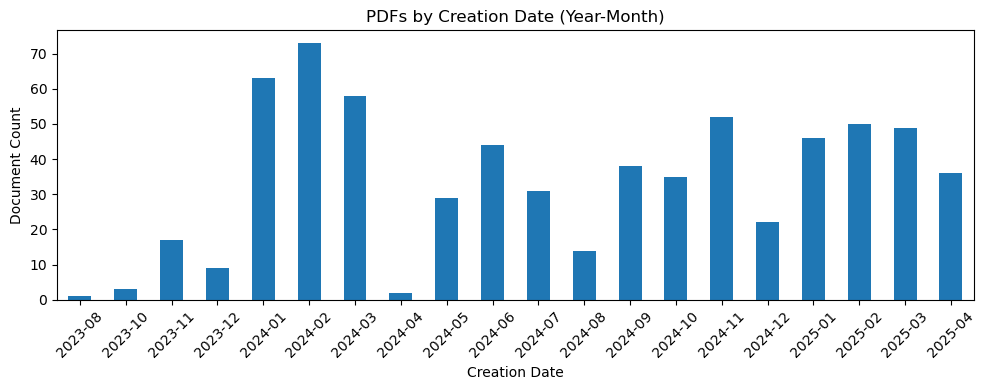

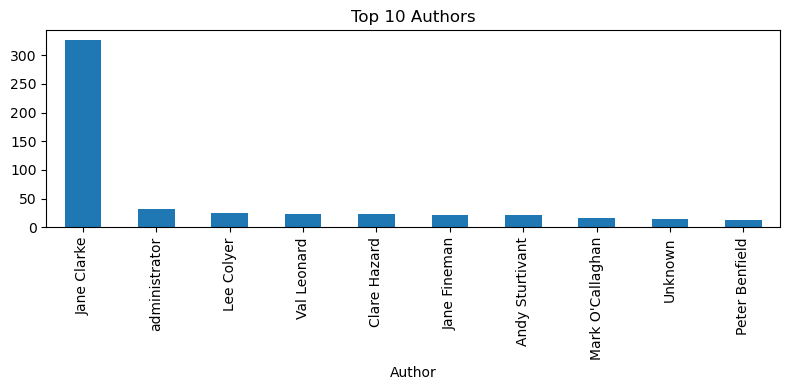

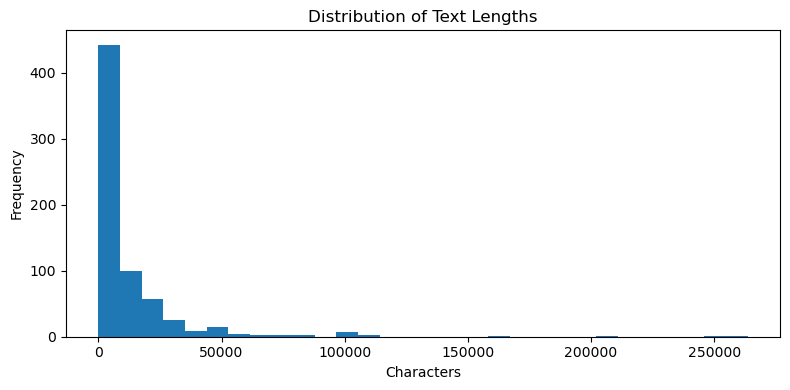

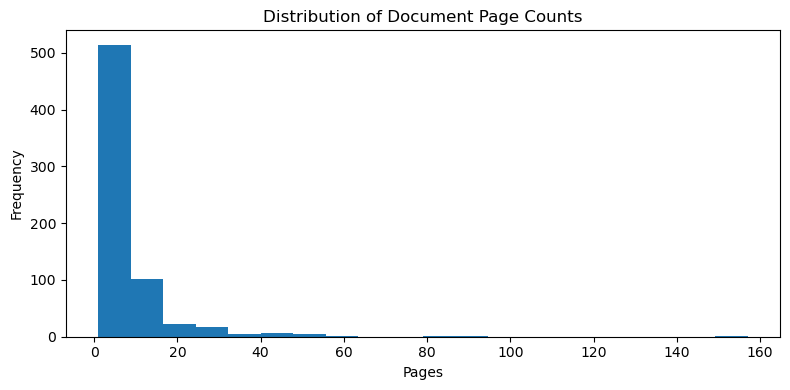

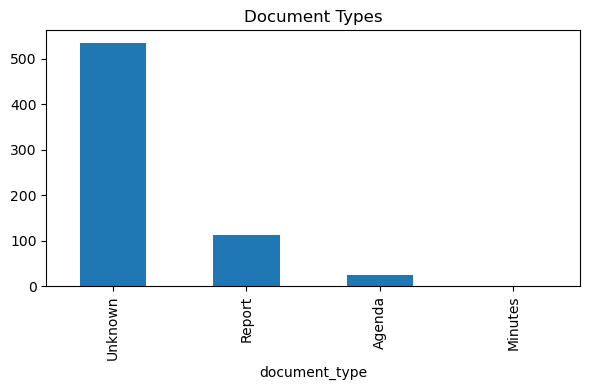

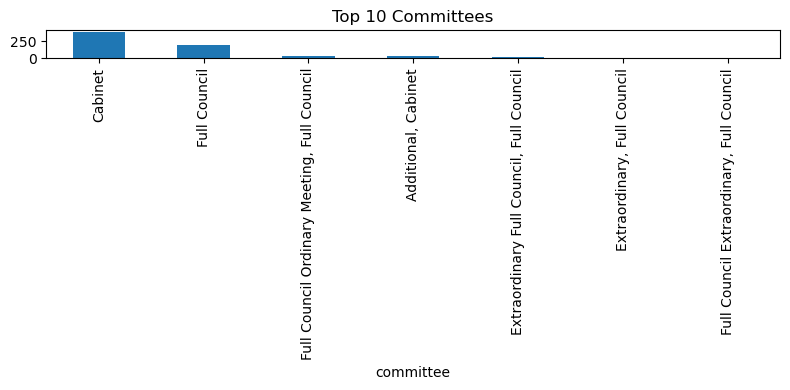

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import re
from datetime import datetime

# Load enriched metadata
#jsonl_path = "/Users/lgfolder/Downloads/raw_scraped_metadata_rtw_test_enriched.jsonl"
with jsonlines.open(jsonl_path) as reader:
    records = list(reader)

# Drop text field for performance
for r in records:
    r.pop("text", None)

df = pd.DataFrame(records)

# === Fix PDF metadata date format (e.g., D:20240313121419+00'00') ===
def clean_pdf_date(date_str):
    if not isinstance(date_str, str) or not date_str.startswith("D:"):
        return None
    try:
        match = re.match(r"D:(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})", date_str)
        if match:
            y, m, d, h, mi, s = map(int, match.groups())
            return datetime(y, m, d, h, mi, s)
    except Exception:
        return None
    return None

df["created_parsed"] = df["created"].apply(clean_pdf_date)
df["year_month"] = df["created_parsed"].dt.to_period("M")

# === Parse meeting_date to YYYY-MM-DD ===
df["meeting_date_parsed"] = pd.to_datetime(df["meeting_date"], errors="coerce", dayfirst=True)

# === Additional prep ===
df["author_clean"] = df["author"].fillna("Unknown")
df["text_length"] = df["char_count"]  # Already computed earlier
df["pages"] = pd.to_numeric(df["pages"], errors="coerce")

# === Visualizations ===

# 1. Creation date distribution
if df["year_month"].notna().any():
    plt.figure(figsize=(10, 4))
    df["year_month"].value_counts().sort_index().plot(kind="bar")
    plt.title("PDFs by Creation Date (Year-Month)")
    plt.xlabel("Creation Date")
    plt.ylabel("Document Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Top 10 authors
plt.figure(figsize=(8, 4))
df["author_clean"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Authors")
plt.xlabel("Author")
plt.tight_layout()
plt.show()

# 3. Text length distribution
plt.figure(figsize=(8, 4))
df["text_length"].plot(kind="hist", bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters")
plt.tight_layout()
plt.show()

# 4. Page count distribution
plt.figure(figsize=(8, 4))
df["pages"].plot(kind="hist", bins=20)
plt.title("Distribution of Document Page Counts")
plt.xlabel("Pages")
plt.tight_layout()
plt.show()

# 5. Document type
if "document_type" in df:
    plt.figure(figsize=(6, 4))
    df["document_type"].value_counts().plot(kind="bar")
    plt.title("Document Types")
    plt.tight_layout()
    plt.show()

# 6. Committee counts
if "committee" in df:
    plt.figure(figsize=(8, 4))
    df["committee"].value_counts().head(10).plot(kind="bar")
    plt.title("Top 10 Committees")
    plt.tight_layout()
    plt.show()

# 7. Numeric density
if "number_density" in df:
    plt.figure(figsize=(6, 4))
    df["number_density"].plot(kind="hist", bins=30)
    plt.title("Numeric Density Distribution")
    plt.xlabel("Numbers per Word")
    plt.tight_layout()
    plt.show()

# 8. Table-heavy flag
if "is_table_heavy" in df:
    plt.figure(figsize=(4, 4))
    df["is_table_heavy"].value_counts().plot(kind="bar")
    plt.title("Table-Heavy Documents")
    plt.xlabel("True / False")
    plt.tight_layout()
    plt.show()

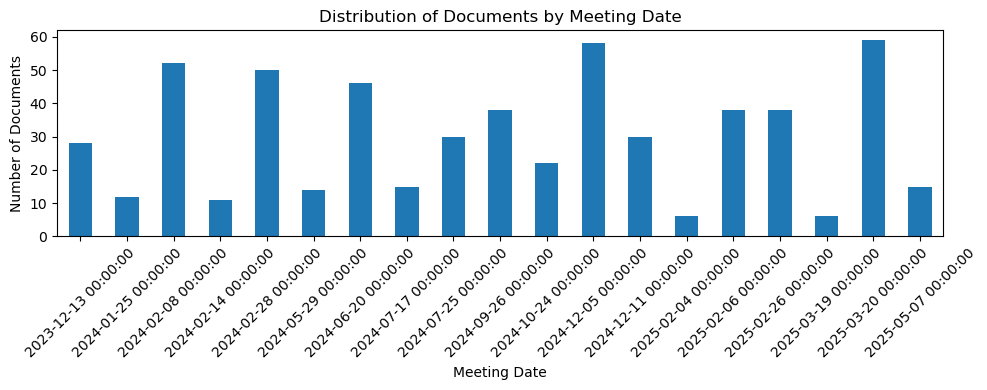

In [66]:
# Group by parsed meeting date
if df["meeting_date_parsed"].notna().any():
    plt.figure(figsize=(10, 4))
    df["meeting_date_parsed"].value_counts().sort_index().plot(kind="bar")
    plt.title("Distribution of Documents by Meeting Date")
    plt.xlabel("Meeting Date")
    plt.ylabel("Number of Documents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid meeting_date found.")

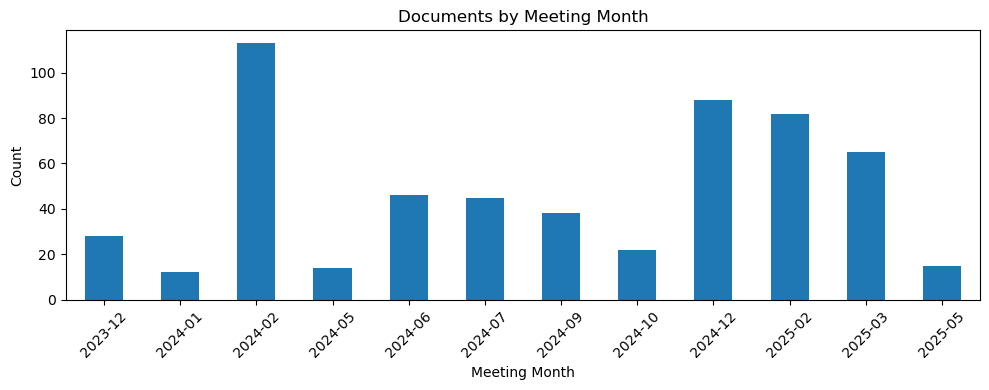

In [67]:
df["meeting_month"] = df["meeting_date_parsed"].dt.to_period("M")
df["meeting_month"].value_counts().sort_index().plot(kind="bar", figsize=(10, 4))
plt.title("Documents by Meeting Month")
plt.xlabel("Meeting Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Maidstone (encoded)

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
import base64
import time
import json
import os
import re

# Load the CSV file
df = pd.read_csv("/Users/lgfolder/Downloads/maidstone.csv")

# Set for visited URLs to prevent duplicates
visited = set()

# Path to results file
results_path = "/Users/lgfolder/Downloads/pdf_results_maidstone.json"
if os.path.exists(results_path):
    with open(results_path, "r") as f:
        results_log = json.load(f)
else:
    results_log = []

# Helper: Check if a URL points to a PDF
def is_pdf(url):
    return url.lower().endswith(".pdf")

# Helper: Allow only ieListDocuments URLs with CId and MId (order-insensitive)
def is_allowed_ieListDocuments_url(url):
    if not isinstance(url, str):
        return False
    parsed = urlparse(url)
    if "ieListDocuments.aspx" not in parsed.path:
        return False
    query = parse_qs(parsed.query)
    return "CId" in query and "MId" in query

# Helper: Check if it's a valid starting page (meeting list or embedded list)
def is_valid_start_url(url):
    return isinstance(url, str) and url.startswith("http") and (
        "ieListMeetings.aspx" in url or "sq_content_src" in url)

# Decode Maidstone-style embedded links

def extract_embedded_url(url):
    parsed = urlparse(url)
    qs = parse_qs(parsed.query)
    sq_encoded = qs.get("sq_content_src", [None])[0]
    if not sq_encoded:
        return None
    try:
        decoded = base64.b64decode(sq_encoded[1:]).decode("utf-8")  # strip +
        real_url = parse_qs(decoded).get("url", [None])[0]
        return unquote(real_url) if real_url else None
    except Exception:
        return None

# Crawl PDFs from a specific meeting document page
def crawl_ieListDocuments_page(url, topic, source_url, depth=0, max_depth=2):
    pdf_links = set()
    if depth > max_depth or url in visited:
        return pdf_links

    if not is_allowed_ieListDocuments_url(url):
        return pdf_links

    visited.add(url)
    print(f"Crawling: {url} (depth={depth})")

    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return pdf_links
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")

    # Try to extract committee, date, and time from a heading
    committee = date = time_ = None
    heading_text = soup.find(string=re.compile(r" - .*\d{1,2}.*\d{4}"))
    if heading_text:
        match = re.match(r"(?P<committee>.+?) - .*?(?P<date>\d{1,2}(?:st|nd|rd|th)?\s+\w+,\s+\d{4})\s+(?P<time>\d{1,2}\.\d{2}\s*[ap]m)", heading_text.strip(), re.IGNORECASE)
        if match:
            committee = match.group("committee").strip()
            date = match.group("date").strip()
            time_ = match.group("time").strip()

    for a_tag in reversed(soup.find_all("a", href=True)):
        link = urljoin(url, a_tag['href'])
        if is_pdf(link):
            if link not in pdf_links:
                pdf_links.add(link)
                # Save immediately with metadata
                results_log.append({
                    "topic": topic,
                    "source_url": source_url,
                    "page_url": url,
                    "pdf_url": link,
                    "committee": committee,
                    "date": date,
                    "time": time_
                })
                with open(results_path, "w") as f:
                    json.dump(results_log, f, indent=2)
        time.sleep(0.25)

    return pdf_links

# Top-level crawler: start from meeting list, extract child meeting document pages
def crawl_from_meeting_list(start_url, topic):
    meeting_pdf_links = set()

    # Decode embedded URL if present
    embedded_url = extract_embedded_url(start_url)
    if embedded_url:
        print(f"Resolved embedded URL: {embedded_url}")
        start_url = embedded_url

    print(f"Scanning meeting list: {start_url}")
    try:
        resp = requests.get(start_url, timeout=10)
        if resp.status_code != 200:
            return meeting_pdf_links
    except Exception as e:
        print(f"Failed to fetch meeting list page {start_url}: {e}")
        return meeting_pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")
    for a_tag in soup.find_all("a", href=True):
        link = urljoin(start_url, a_tag['href'])
        if is_allowed_ieListDocuments_url(link):
            meeting_pdf_links |= crawl_ieListDocuments_page(link, topic, start_url)
            time.sleep(0.25)

    return meeting_pdf_links

# Run crawler for each topic
pdf_map = {}
for _, row in df.iterrows():
    topic = row.get('topic')
    start_url = row.get('mother_url')

    if not is_valid_start_url(start_url):
        print(f"Skipping (not allowed): {start_url}")
        continue

    visited.clear()
    pdf_links = crawl_from_meeting_list(start_url, topic)
    pdf_map[topic] = list(pdf_links)
    print(f"Saved {len(pdf_links)} PDFs for topic: {topic}\n")

# The pdf_map now holds topic -> [list of PDF URLs]
